# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# **Trabajo Practico 2**
### Filtrado lineal óptimo 

**Group 1:** Sofia Yanes Sanchez and Marco Zaiser

**Date:** 24.09.2025 

In [1]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import pandas as pd
import scipy.signal as sp
import matplotlib.pyplot as plt
import librosa
import scipy.linalg as la
import os

# interactive plots
%matplotlib widget 

## 1. Production and Recording 
The goal of this project is to model the impulse response $h(n)$ of a speaker-room-microphone system with an adaptive Filter, such as a Wiener Filter if optimal. To achive an precise model, the system must be excited by a thoughtfully desinged input signal $u$. To justify the selection of the voice/music signal to excite the system we thought of the follwing objectives:

1. Main Objective: The signals should excite the system in as many frequencys as possible or at least in the frequencys of our interest. Therefore the signal should have a very broad frequency spectrum.
2. The optimal signal should contain no harmonic frequencys. To avoid introducing harmonic content that isn`t part of the system.
3. The input signals should have a high Signal-to-Noise Ratio (SNR). Because a signal with high SNR gurantees that the measured response reflects the rooms characteristics and not noise artifacts of $u$. 

In [2]:
fs = 48e3 # [kHz]
duration = 10 # [s]
t = np.linspace(0,duration, int(fs*duration), endpoint=False)
u_dict = {}
n_sync = int(fs/2)
n_delay = int(5*fs)

### 1.a) The Voice
We selected a podcast conversation between a male English speaker and a female Chinese speaker. This combination was chosen to introduce diversity in both gender and language, as male and female voices typically occupy different fundamental frequency ranges, with female voices generally higher in pitch. Additionally, tonal languages like Chinese differ significantly in their  dynamics compared to English, which may provide broader spectral variation. So we achieved a very broad frequency spectrum.
To minimize harmonic content, we intentionally avoided using singing voices, which typically produce strong, structured harmonics. Instead, we opted for spoken language in a podcast format.
Podcasts usually have a very high quality and therefore a high SNR.

In [ ]:
# replay of the voice
# path = r"signals\voice.mp3"
# voice_signal, sample_rate = librosa.load(path, sr=48e3)

In [ ]:
# start_sec = 1895 # [s]
# end_sec = 1905 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_voice = voice_signal[start_sample:end_sample]
# u_dict["u_voice"] = u_voice

# output_path = r"signals\voice_seg.wav"
# sf.write(output_path, u_voice, int(sample_rate), format='WAV')

In [3]:
u_voice, f_voice = librosa.load(r"signals\voice_seg.wav", sr=48000)
u_dict["voice"]  = u_voice

### 1.b) Music
Here we choose a metal song with high diversity. The first reason is, of course, the broad frequency spectrum created by the different instruments.
When we consider the harmonic content, we concluded that there would be a lot of harmonic content due to the high-frequency components from the electric guitars. However, we accept this trade-off to achieve a broader frequency spectrum.
Metal music is typically recorded with consistent, high energy and volume, which results in a high SNR

In [ ]:
# replay of the song
# path = r"signals\song.mp3"
# music_signal, sample_rate = librosa.load(path, sr=48e3) # problem: sr = 44.1 naturally, this is due to the mp3 format.

We are upsampeling the originally signal which we downloaded from youtube to 48 kHz. Usually mp3 uses a f_s of 44.1 kHz. But the signal displayed from youtube is at 48 kHz. So we are fine, it just leads to some issues in the comparison of the power spectrums.

In [ ]:
# start_sec = 53 # [s]
# end_sec = 63 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_music = music_signal[start_sample:end_sample]
# u_dict["u_music"] = u_music
# output_path = r"signals\music_seg.wav"
# sf.write(output_path, u_music, int(sample_rate), format='WAV')

In [4]:
u_music, fs_music = librosa.load(r"signals\music_seg.wav", sr=48000)
u_dict["music"]  = u_music

### 1.c) rectangular signal

In [5]:
a = 1
f = 100
u_rec = a*np.sign(np.sin(2*np.pi*f*t))
u_dict['rec'] = u_rec

### 1.d) linear sweep

In [6]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)/duration 
u_l = np.sin(2*np.pi*f_0 + np.pi*k*t**2)
u_dict['lin'] = u_l

### 1.e) exponential sweep

In [7]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)**(1/duration) 
u_e = np.sin(2*np.pi*f_0*((k**t)-1)/np.log(k))
u_dict['exp'] = u_e

### 1.f) white noise with zero mean

In [8]:
u_wn = np.random.normal(0,1, len(t))
u_dict['wn'] = u_wn

It is very important that the excitations and the outputs of our system align, because Wiener filtering rely on a precise temporal relationship between input and output (f.e. calculating the crosscorrelation of  the input and output signal). Therefore we want to implement a synchronization signal before the actual excitation is played in the room. The general idea is that we synchronize the microphone and the speaker with a rectangular signal with the microphone very close to the speaker. Because we want here only the signal to synchronize without interaction of the room. Later, we will align the input and output signals by aligning the synchronization signal by hand in the program Audacity.

In [ ]:
# adding the Synchronization:

# u_dict_synch = {}
# for key, u in u_dict.items():
#     u_sync = np.concatenate([u_rec[:n_sync], np.zeros(n_delay)])
#     u_dict_synch[key] = np.concatenate([u_sync, u_dict[key]]) 

# print(u_dict_synch)

{'wn': array([ 0.        ,  1.        ,  1.        , ...,  0.08342247,
        0.76434028, -0.46511738], shape=(744000,)), 'voice': array([0.        , 1.        , 1.        , ..., 0.0375061 , 0.03997803,
       0.04354858], shape=(744000,)), 'music': array([0.        , 1.        , 1.        , ..., 0.06616211, 0.09118652,
       0.10839844], shape=(744000,)), 'rec': array([ 0.,  1.,  1., ..., -1., -1., -1.], shape=(744000,)), 'lin': array([ 0.        ,  1.        ,  1.        , ..., -0.99996896,
        0.86863691, -0.50226789], shape=(744000,)), 'exp': array([ 0.        ,  1.        ,  1.        , ..., -0.91152084,
        0.77856153,  0.20729165], shape=(744000,))}


In [ ]:
# sf.write(r"signals\inputs\voice.wav", u_dict_synch["voice"], int(fs)) # save u as .wav files

In [ ]:
# # To play the Signals
# sd.play(u_dict_synch["rec"], samplerate=fs)
# sd.wait()

## 2. Best signal for estimation
For a accurate analysis, we apply windowing to all non peridoic signals, excpet the white noise. As discussed in the lecture, windowing has no significant effect on white noise due to its properties. 

In our opinion the white noise will lead to the best model of the impulse response $h(n)$ of the speaker-room-microphone system. According to our main objective, the system should be excited in all the frequencys of our interest. Only the exponential $u_{exp}$ and the white noise signal $u_{wn}$ can achieve this, because they provide a broad frequency spectrum. However the other signals have not enough power in the high frquencys ranges, therefore making them less effective for a complete system identification.
Furthermore does the $u_{wn}$ excite all frequencys with the same power. 

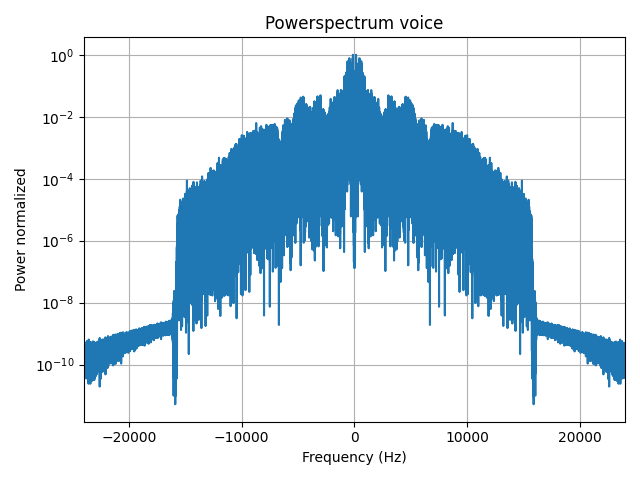

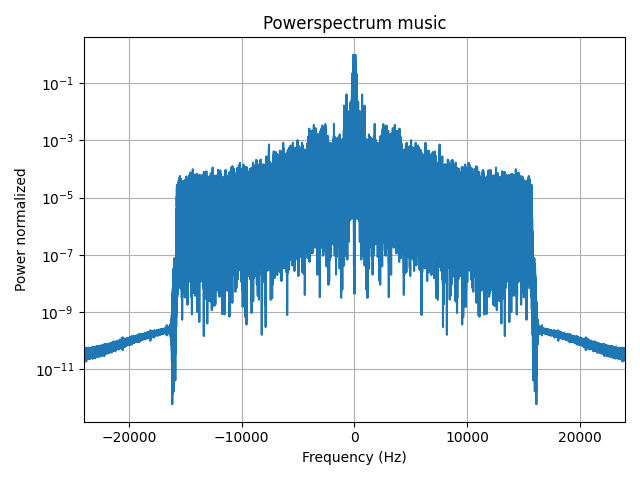

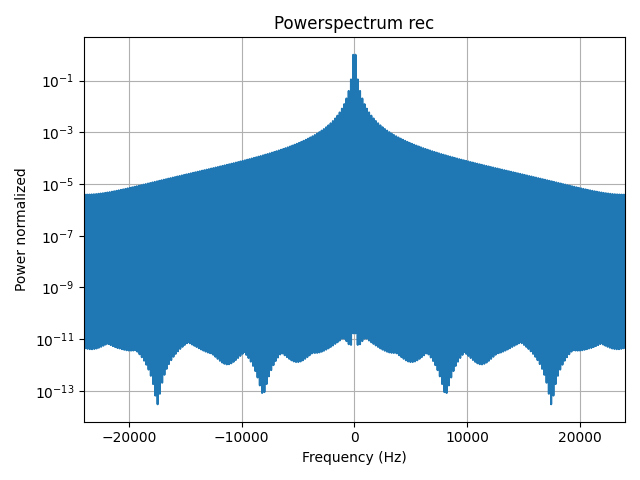

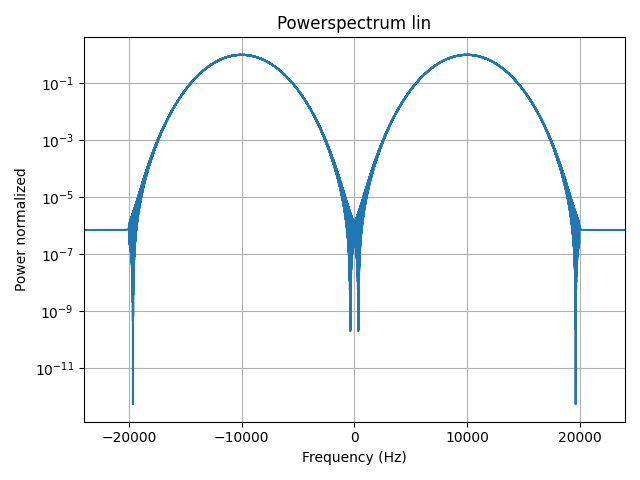

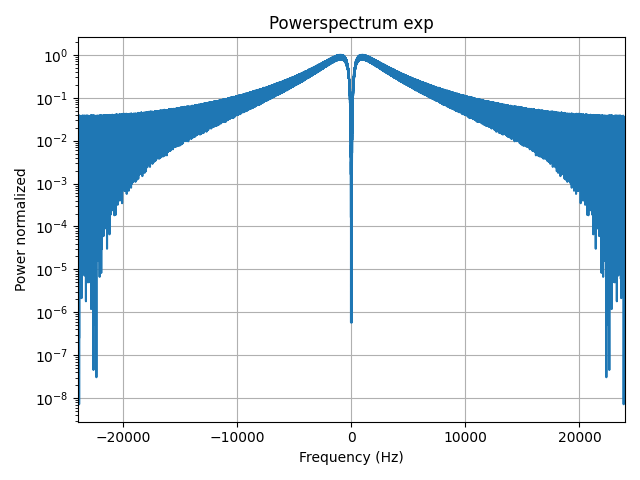

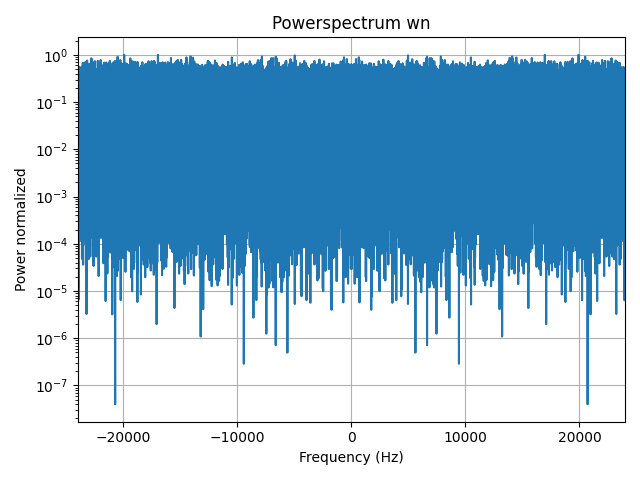

In [9]:
# calculate powerspectrum of the different input signals
f = np.fft.fftshift(np.fft.fftfreq(len(t), d=1/fs)) 
windowing = 1
for key, u in u_dict.items():
    if (key != "u_rec" or key != "u_wn") and windowing == 1:
        window = sp.windows.chebwin(len(u), 100) # windowing to reduce the spectral leakage
        u_win = u * window
    else:
        u_win = u
    U = np.fft.fft(u_win)
    R_u = (U * np.conj(U)) / len(u) # skaling to singal length
    R_u = np.fft.fftshift(np.abs(R_u))
    R_u /= np.max(R_u) # normalizing for better comparision
    plt.figure()
    plt.semilogy(f, R_u)
    plt.title(f"Powerspectrum {key}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power normalized")
    plt.grid(True)
    plt.xlim(-1/2*fs, 1/2*fs)
    plt.tight_layout()

# psds for voice makes no sense.... Voice has max frequency of 80000 Hz 


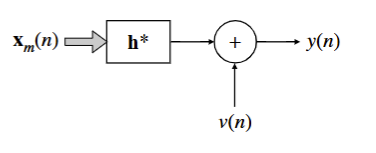

## 3. optimal filterorder $M$

In the following we calculate the optimal filterorder $M$, by determine the value of the optimal root mean square error (MSE) $J_o$ for different $M$:

$J_0 = \sigma_y^2 - \mathbf{p}^H \mathbf{R}^{-1} \mathbf{p} = \sigma_y^2 - \mathbf{p}^H \mathbf{w}_o$

We decided to calculate $\mathbf{w}_o$ by solving the normal equation system $\mathbf{R} \mathbf{w}_o = \mathbf{p}$ instead of calculating the inverse $\mathbf{R}^{-1}$. Calculataing the inverse is usually more expensive and numarically unstable. But it is possible to calculate $\mathbf{w}_o$ even more efficient  with the Levinson-Durbin Algorithm, that would lead to a computational complexity to $\mathcal{O}(n^2)$ instead of $\mathcal{O}(n^3)$.

After trying to calculate the optimal Filter length $M$ we figured out, that we have to cut off the first part and the last part of our output $y$ & input $u$. 
The reason for the cutoff is, the sound travels at the speed of $v_s = 343 m/s$. Therefor the room needs time be excited, dependent on the size of the room.
Furthermore that also means at the beginning the convolution the unknown impulse reponse is only partially developed.
Similarly, at the end of the recorded signal, the convolution is again incomplete. The end of the impulse response may extend beyond the available input, meaning the output no longer reflects the full system behavior. These edge effects, caused by limitation by the speed of sound, introduce errors and bias in the estimation process.

Its very important that the input $u$ and the output $y$ align. We tried to achieve this as discribed above in the program audacity.

In [28]:
folder_path = r"signals\outputs_sync"
y_dict = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    y, f_y = librosa.load(file_path, sr = fs) 
    key = os.path.splitext(filename)[0]
    y_dict[key] = y


In [11]:
folder_path = r"sofias_things"
y_dict = {}
start = n_delay+n_sync
end = int(start+duration*fs)
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    y, f_y = librosa.load(file_path, sr = fs) 
    key = os.path.splitext(filename)[0]
    y_dict[key] = y[start:end]
    # plt.figure()
    # plt.title(f"{key}")
    # plt.plot(y_dict[key])


C:\Users\Marco\AppData\Local\Temp\ipykernel_38156\1874001562.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


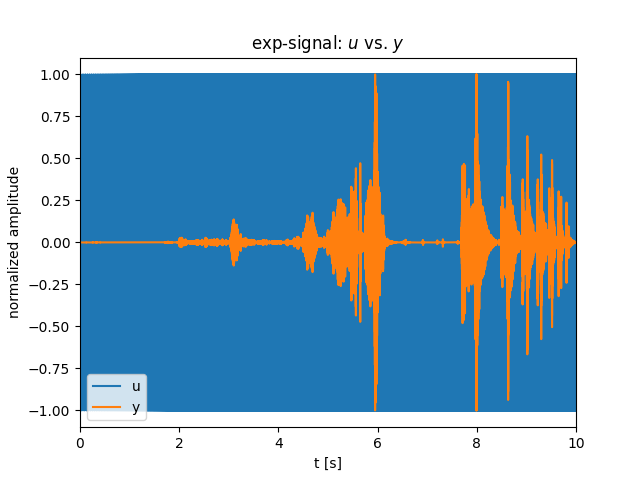

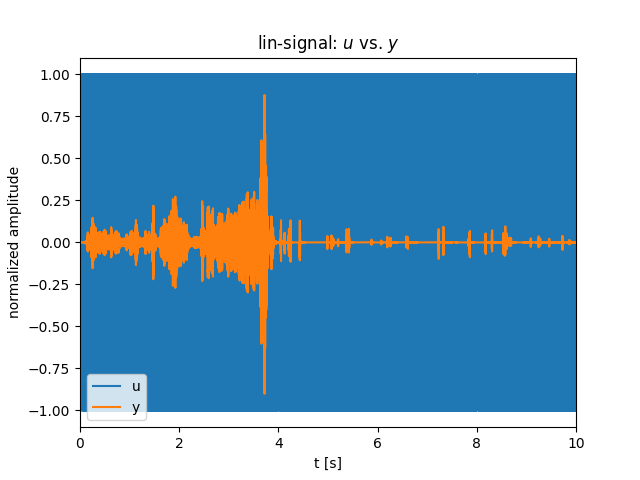

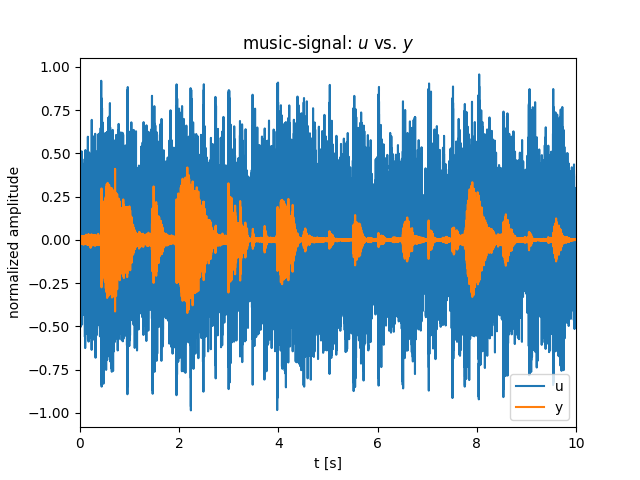

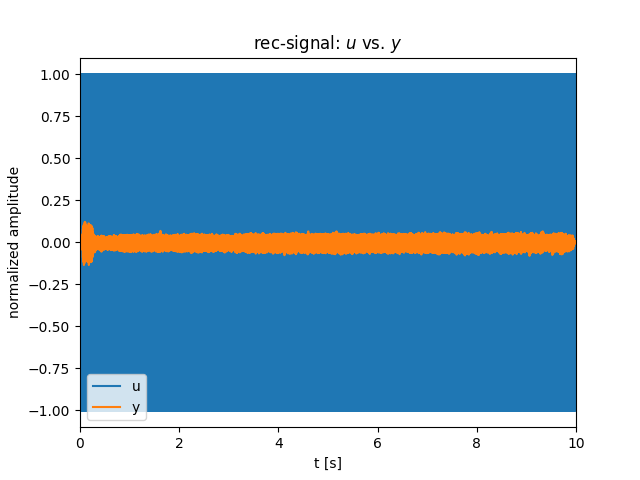

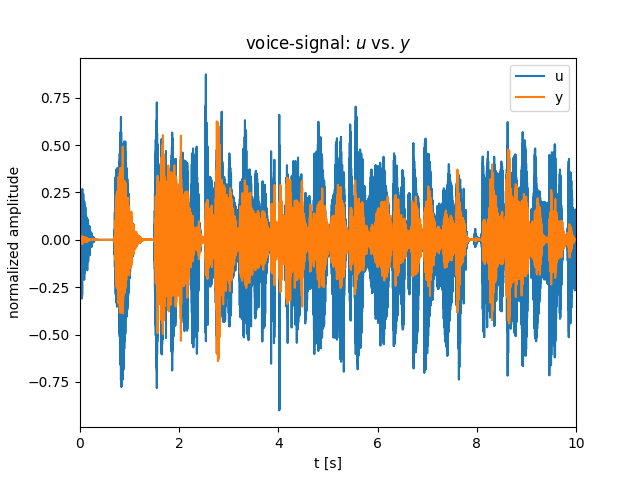

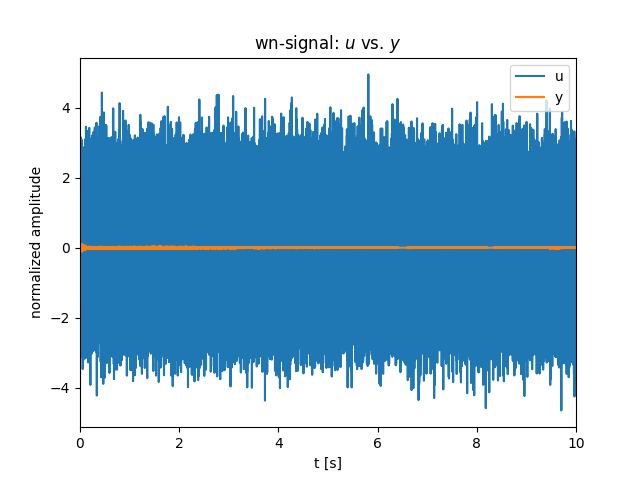

In [12]:

for key, y in y_dict.items():
    if len(y) < len(u_dict[key]):
        y_dict[key] = np.pad(y,(0,int(len(u_dict[key])-len(y))), 'constant') 
    elif len(y) > len(u_dict[key]):
        y_dict[key]= y[:len(u_dict[key])]
    plt.figure()
    plt.title(f"{key}-signal: $u$ vs. $y$")
    plt.plot(t, u_dict[key], label = "u")
    plt.plot(t, y_dict[key], label = "y")
    plt.xlabel("t [s]")
    plt.ylabel("normalized amplitude")
    plt.xlim(0,10)
    plt.legend()


In [13]:
# Helper functions 

def is_hermitian(R, tol=1e-10):
    return np.allclose(R, R.conj().T, atol=tol)

def is_positive_definite(R):
    eigvals = np.linalg.eigvalsh(R)  # eigvalsh for Hermitian matrices (faster and more stable)
    return np.all(eigvals > 0)

def is_positive_semidefinite(R, tol=1e-12):
    eigvals = np.linalg.eigvalsh(R)
    return np.all(eigvals >= -tol)  # small negative tol accounts for numerical errors


def check_R(R):
    if not is_hermitian(R):
        print("Matrix R is NOT Hermitian!")
    else:
        print("Matrix R is Hermitian.")

    if is_positive_definite(R):
        print("Matrix R is positive definite.")
    elif is_positive_semidefinite(R):
        print("Matrix R is positive semi-definite.")
    else:
        print("Matrix R is NOT positive (semi-)definite.")


In [29]:
cut_off = int(fs)
cut_off_2 = int(duration*fs - cut_off)
x = u_dict["lin"]
y = y_dict["lin"]
x = x[cut_off:cut_off_2]
y = y[cut_off:cut_off_2]

sigma_y2 = np.mean(np.abs(y)**2)  # E{|y|^2}

X = np.fft.fft(x)  # FFT of signal windowing for spectral leakage
Y = np.fft.fft(y)
N = len(x)
rxx = np.fft.ifft(X * np.conj(X)) / N # autocorrelation SEQUENCE
pxy = np.fft.ifft(Y * np.conj(X)) / N

Jo_tab = []
M_tab = np.concatenate([np.array([1, 100, 200, 500]), np.arange(1000, 25001, 1000)])

with open("output_results.txt", "w") as f:

    for M in M_tab:
        R = la.toeplitz(rxx[:M])  # autocorrelation matrix 
        p = np.conj(pxy)[:M]  # cross correlation vector
        # check_R(R)
        r = rxx[:M]  # first column of Toeplitz matrix
        c = rxx[:M] 
        wo = la.solve_toeplitz((c, r), p) # more efficient
        # wo = la.solve(R, p)
        Jo = sigma_y2 - np.conj(p) @ wo  # sigma_y^2 - p^H R^-1 p
        Jo_tab.append(np.real(Jo))  # imaginary parts are e-14 and are just floating point error basically
        f.write(f"{M},{Jo.real}\n")

In [27]:
# helper function to save the results
data = np.loadtxt("output_results.txt", delimiter=",")
M_tab = data[:,0]
Jo_tab = data[:,1]

[2.17216553e-03 2.14985545e-03 1.74169862e-03 1.04219278e-03
 7.67064045e-04 6.00301956e-04 5.25146848e-04 4.47264559e-04
 3.65438535e-04 2.77700133e-04 2.24861127e-04 1.72655656e-04
 1.52067198e-04 1.35798158e-04 1.23762693e-04 1.17345981e-04
 1.12344423e-04 1.06776901e-04 1.04560985e-04 1.03243704e-04
 1.01635356e-04 1.00425379e-04 9.98333750e-05 9.94649957e-05
 9.91384598e-05 9.89477203e-05 9.88349048e-05 9.87165700e-05
 9.85243396e-05]


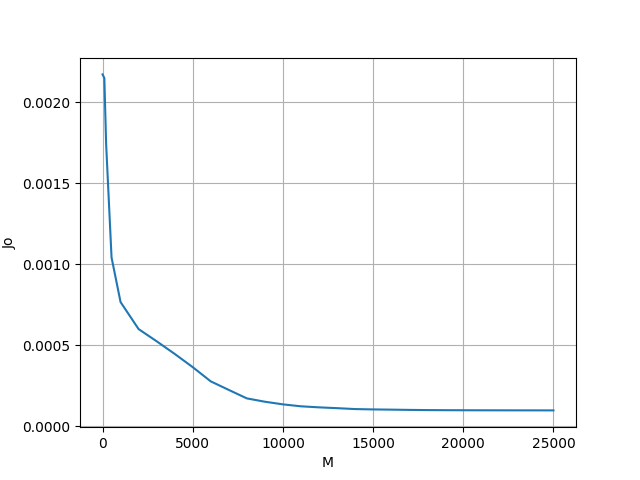

In [30]:
plt.figure()
plt.plot(M_tab, Jo_tab)
plt.xlabel("M")
plt.ylabel("Jo")
plt.grid()
print(np.array(Jo_tab))

The results show that $J_0$ decreases significantly with increasing $M$ at first, but the improvement becomes marginal beyond approximately $M = 15000$.

For example, $J_0$ drops from $2.17 \times 10^{-3}$ at $M = 1$ to approximately $1.04 \times 10^{-4}$ at $M = 15000$. Increasing $M$ further to $25000$ yields only a slight improvement, reaching a minimum of about $9.85 \times 10^{-5}$. This corresponds to a relative gain of less than 6\%, while increasing the filter length by 66\%.

Therefore, we select $M = 15000$ as a good tradeoff between performance and computational efficiency. 


## 4. Estimation of $h(n)$ and more

compare between the different signals we recorded --> conclusions about which
ones excite the frequency spectrum more hence allow us to build a better filter
for the room.

In [19]:
# Helperfunction to create a combined dictionary: i_dict = { "i": (u_i, y_i) }
sig_dict = {}
for key in u_dict:
    if key in y_dict:
        sig_dict[key] = (u_dict[key], y_dict[key])

In [20]:
M = 15000  # optimal M from previous question
response_dict = {}
cut_off = int(2*fs)
cut_off_2 = int(duration*fs - cut_off)
for key, (u, y) in sig_dict.items():

    x = u[cut_off:cut_off_2]
    y = y[cut_off:cut_off_2]

    sigma_y2 = np.mean(np.abs(y)**2)  # E{|y|^2}

    X = np.fft.fft(x)  # FFT 
    Y = np.fft.fft(y)
    N = len(x)

    rxx = np.real(np.fft.ifft(X * np.conj(X)) / N) # autocorrelation SEQUENCE
    pxy = np.real(np.fft.ifft(Y * np.conj(X)) / N)

    R = la.toeplitz(rxx[:M])  # autocorrelation matrix 
    p = np.conj(pxy)[:M]  # cross correlation vector

    # characteristic equation: Rw_o = p
    r = rxx[:M]  # first column of Toeplitz matrix
    c = rxx[:M] 
    w_o = la.solve_toeplitz((c, r), p) # more efficient

    '''
    H_hat tells us how the room modifies each frequency, so basically which 
    frequencies are amplified, attenuated, or delayed etc 
    '''
    H_hat = np.fft.fft(w_o)  # the frequency response
    f = np.fft.fftfreq(len(w_o), d=1/fs)

    '''
    E = 1 - sigma_yhato^2 / sigma_y^2
    sigma_y^2 = E{|y|^2} --> we're estimating this with just a mean
    sigma_yhato^2 = E{|y_hato|^2} = p^H w_o
    '''
    sigma_y_hato2 = np.conj(p) @ w_o
    MSE_normalizado = 1 - sigma_y_hato2 / sigma_y2 #explained variance?
    np.real(MSE_normalizado) # complex parts are numerical artivacts due to FFT

    response_dict[key] = (w_o, H_hat, MSE_normalizado)



Sorted NMSE values:
lin: MSE_norm = 0.050406383094807605
exp: MSE_norm = 0.3290454349297921
voice: MSE_norm = 0.3922809719343525
rec: MSE_norm = 0.5989870865298837
music: MSE_norm = 0.713513961330789
wn: MSE_norm = 0.9482725137691073


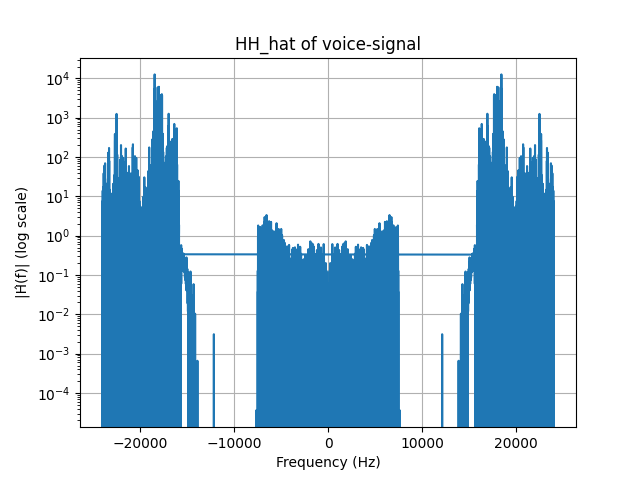

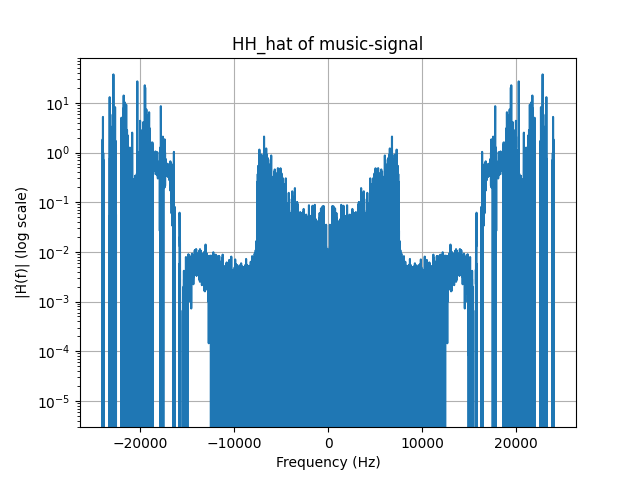

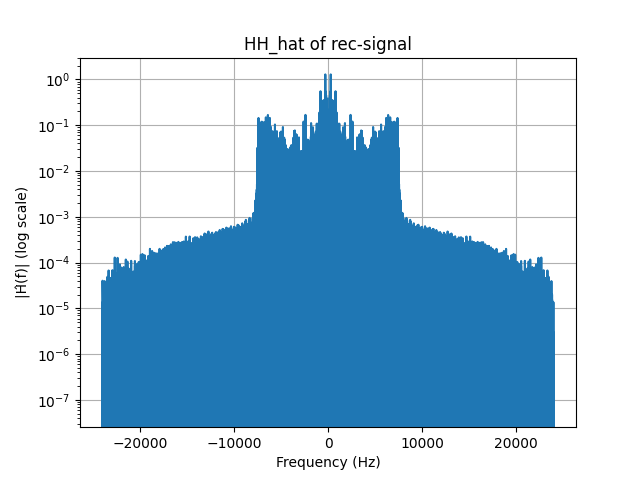

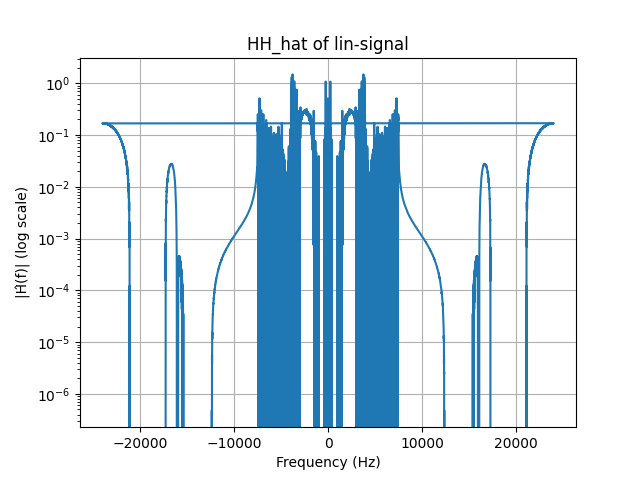

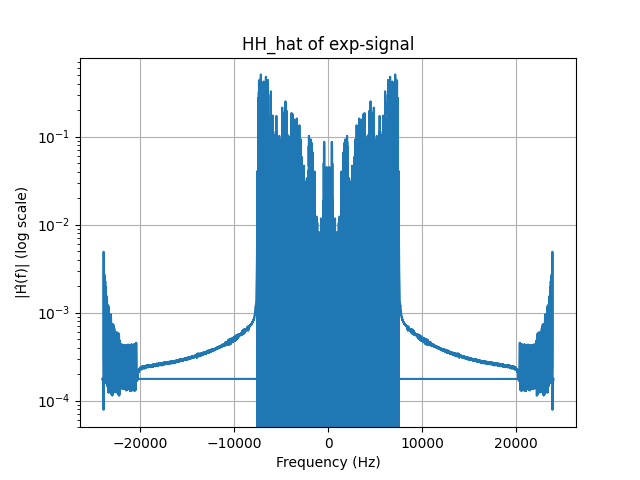

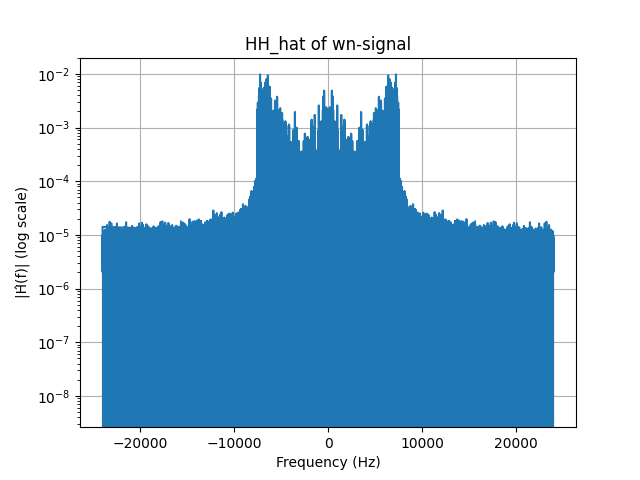

In [ ]:
mse_list = []

# Collect MSE_norm values and signal names
for key, (w_o, H_hat, MSE_normalizado) in response_dict.items():
    mse_list.append((key, MSE_normalizado))

    # Plot H_hat
    plt.figure()
    plt.semilogy(f, H_hat)
    plt.title(f"H_hat of {key}-signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("H_hat")
    plt.grid(True)

# Sort the list by MSE_norm (ascending)
mse_list.sort(key=lambda x: x[1])

# Print sorted results
print("\nSorted NMSE values:")
for name, nmse in mse_list:
    print(f"{name}: MSE_norm = {nmse}")

The smallest normalized mean square error (NMSE) is observed for the linear sweep signal $u_{lin}$​. This is expected, as the filter order $M$ was specifically determined based on this signal. The linear sweep has a bandlimited spectrum that sufficiently excites the relevant frequencies for accurate system identification, making the chosen filter length well-matched to the system response $h(n)$.

In contrast, the white noise $u_{wn}$ signal has the worst NMSE. Although white noise has a theoretically flat and broad spectral content, the filter order $M$, optimized for the bandlimited $u_lin$, is too small to capture the full system dynamics excited by the white noise. Moreover, the random nature in white noise make it difficult for the Wiener filter to estimate effectively, further degrading performance.

The exponential excitation $u_{exp}$ achieves the next best NMSE after the linear sweep. While it also covers a broad frequency range, it benefits from having a clear temporal structure, allowing the Wiener filter to estimnate efficiently. This structured excitation balances spectral richness and temporal predictability, which improves estimation accuracy relative to random signals.

As previously mentioned, the filter faces challenges with random and bandlimited natural signals such as voice and music. These signals are inherently difficult to predict due to their nonstationary and complex nature. Despite this, the filter performs relatively well with the voice signal, achieving an NMSE of approximately 0.39, because speech contains structured temporal patterns and a somewhat stable spectral envelope within its limited bandwidth. On the other hand, the music signal results in a higher NMSE (about 0.71), likely because music encompasses a wider dynamic range, more complex spectral variations, and less predictability, making it harder for the filter to capture the system response accurately.

Finally, the rectangular signal $u_{rec}$produces an intermediate NMSE (around 0.60). The poor spectral coverage means that many frequency components of the system response remain unexcited, limiting the filter’s ability to estimate the system accurately. Thus, its performance is worse than broadband excitations like the linear and exponential sweeps but better than the complex, unstructured white noise or music signals.

Generally speaking you can say, that the closer $H_{hat}$ is to the one produced by the linear sweep, the lower is the NMSE. 

## 5. Comparision 

In point 2 we expected that the excitation by white noise will do best, due to its broad frequency spectrum, but actually it did worst. This is because of several points which are already mentioned in 4:
1. the filter order M is to small
2. white noise is random and therefore its hard for the Wiener filter to estimate
At least we were right with the second best exciting signal to estimate the frequency response, the exponential signal. 

At least we expected that the exponential sweep will be good thanks to it broad spectrum. 

## 6. Best estimation of $h(n)$

The best h(n) should be one with lowest NMSE in our case the estimation of the system with $u_lin"
The music recorded in the room can be described as y(n) = x(n) * h(n) where x(n) is the og music
and its convoluted by the room so we want an inverse filter
since convolution in the time domain is multiplication in the frequency domain
so Y(f) = X(f) H(f) --> X(f) = Y(f) / H(f)

In [39]:
y = y_dict["lin"]
w_o, H_hat, MSE_normalizado = response_dict["exp"]
Y = np.fft.fft(y)  # putting signal into frequency domain
H_hat_pad = np.fft.fft(H_hat, n=len(Y)) #zwero padding
X_hat = Y / H_hat_pad  # "unconvoluting" the signal in the frequency domain
x_hat = np.fft.ifft(X_hat)  # bringing it back to the time domain


In [40]:
sd.play(x_hat.real, samplerate=fs)
sd.wait()

The filtered output is 